In [1]:
import numpy as np
import pandas as pd
from db_form import parameters_form
from db_dataverse import SampleDataverseTable, JVScanDataverseTable 
from datetime import date, datetime
import time
import os
import json
import lmfit as lm
import matplotlib.pyplot as plt
%matplotlib widget

# Import functions from our new functions.py file
from functions import (
    epoch_to_timestamp, timestamp_to_epoch, dataframe_clumping, 
    read_json_file, get_parameter_details, plot_time_series_from_form,
    make_error_boxes, filter_dataframe_for_boxplot, my_boxplot_comparison1,
    Constant, Stretch_Exp, color # also importing the color class if used in notebook directly
)


In [2]:
crm_url = "https://perovskitedevelop.api.crm.dynamics.com/"
sample_table_logical_name =  "crf3d_sample_datas"
Sample_table_logical_names = {
    "Sample ID": 'crf3d_sampleid', 
    "Operator": 'crf3d_operatorname', 
    "Perovskite Composition": 'crf3d_perovskitecomposition', 
    "HTL Material": 'crf3d_htlmaterial', 
    "ETL Material": 'crf3d_etlmaterial',
    "Top Capping Material": 'crf3d_topcappingpassivationmaterial', 
    "Bottom Capping Material": 'crf3d_bottomcappingpassivationmaterial', 
    "Bulk Passivation Materials": 'new_bulkpassivationmaterial', 
    "Is Encapsulated": 'crf3d_isencapsulated'
}
last_num = 1500
sample_table = SampleDataverseTable(crm_url, sample_table_logical_name, col_logical_names=Sample_table_logical_names)
sample_ids, sample_recent_values, result = sample_table.recent_entries(last_num)
# print(sample_ids) # Optional: uncomment to see sample IDs


In [3]:
JV_scan_table_logical_name = "crf3d_jv_test_datas"
col_logical_names = {
    'sample_id': 'crf3d_sample_id',
    'elapsed_time': 'crf3d_elapsed_time_sec',
    'base_time': 'crf3d_base_time_sec',
    'test_id': 'crf3d_test_id',
    'i_ph_suns': 'crf3d_iph_suns',
    'voc_v': 'crf3d_voc_v',
    'mpp_v': 'crf3d_mpp_v',
    'jsc_ma': 'crf3d_jsc_macm2',
    'rsh': 'crf3d_rsh',
    'rser': 'crf3d_rser',
    'ff': 'crf3d_ff_pct',
    'pce': 'crf3d_pce_pct',
    'operator': 'crf3d_operator_name',
    'scan_type': 'crf3d_scan_type',
    'lab_location': 'crf3d_location',
    'cell_number': 'crf3d_cell_number',
    'module': 'crf3d_module',
    'masked': 'crf3d_masked',
    'mask_area': 'crf3d_mask_area_cm2',
    'temp_c': 'crf3d_temperature_c',
    'hum_pct': 'crf3d_humidity_pct',
    'four_wire_mode': 'crf3d_four_wire_mode',
    'scan_data_path': 'crf3d_scan_path'
}
jv_test_table = JVScanDataverseTable(crm_url=crm_url, table_name=JV_scan_table_logical_name, col_logical_names=col_logical_names)
num_vals = 5000
jv_test_ids, jv_test_recent_values, jv_test_result = jv_test_table.recent_entries(num_vals)

# Add abs_epoch_time if not already present for later use
if 'abs_epoch_time' not in jv_test_recent_values.columns and \
   'base_time' in jv_test_recent_values.columns and \
   'elapsed_time' in jv_test_recent_values.columns:
    try:
        base_time_numeric = pd.to_numeric(jv_test_recent_values['base_time'], errors='coerce')
        elapsed_time_numeric = pd.to_numeric(jv_test_recent_values['elapsed_time'], errors='coerce')
        jv_test_recent_values['abs_epoch_time'] = base_time_numeric + (60.0 * elapsed_time_numeric)
    except Exception as e:
        print(f"WARNING: Could not create 'abs_epoch_time' in notebook: {e}")

jv_test_recent_values.head() # Display head to check


,sample_id,elapsed_time,base_time,test_id,i_ph_suns,voc_v,mpp_v,jsc_ma,rsh,rser,...,lab_location,cell_number,module,masked,mask_area,temp_c,hum_pct,four_wire_mode,scan_data_path,abs_epoch_time
0,050225_FAPI_SA_Cr_Cu_C8,15.8,1747844410.46,050225_FAPI_SA_Cr_Cu_C8_6R_123553,0.8,0.96,0.55,15.71,148.19,28.04,...,Upstairs (W426),6,False,False,0,23,0,False,C:\Users\LabUser\OneDrive - Verde Technologies...,1.747845e+09
1,050225_FAPI_SA_Cr_Cu_C8,15.73,1747844410.46,050225_FAPI_SA_Cr_Cu_C8_6F_123553,0.8,0.9,0.53,14.14,77.13,32.85,...,Upstairs (W426),6,False,False,0,23,0,False,C:\Users\LabUser\OneDrive - Verde Technologies...,1.747845e+09
2,050225_FAPI_SA_Cr_Cu_C8,14.75,1747844410.46,050225_FAPI_SA_Cr_Cu_C8_5R_123451,0.8,0.96,0.69,18.68,289.94,11.64,...,Upstairs (W426),5,False,False,0,23,0,False,C:\Users\LabUser\OneDrive - Verde Technologies...,1.747845e+09
3,050225_FAPI_SA_Cr_Cu_C8,14.69,1747844410.46,050225_FAPI_SA_Cr_Cu_C8_5F_123451,0.8,0.9,0.57,17.61,100.78,22.76,...,Upstairs (W426),5,False,False,0,23,0,False,C:\Users\LabUser\OneDrive - Verde Technologies...,1.747845e+09
4,050225_FAPI_SA_Cr_Cu_C8,13.27,1747844410.46,050225_FAPI_SA_Cr_Cu_C8_4R_123321,0.8,0.98,0.71,19.94,400.8,8.3,...,Upstairs (W426),4,False,False,0,23,0,False,C:\Users\LabUser\OneDrive - Verde Technologies...,1.747845e+09


In [4]:
jupyter_notebook_path = os.getcwd()
print(f"Current Notebook Path: {jupyter_notebook_path}")

sample_filter_1 = '05072025' 
sample_filter_2 = ''
sample_filter_operator = 'and'

if sample_ids: # Check if sample_ids is not empty
    if sample_filter_operator == 'and':
        sample_id_list = [sample_id for sample_id in sample_ids if (sample_filter_1 in sample_id if sample_filter_1 else True) and (sample_filter_2 in sample_id if sample_filter_2 else True)]
    elif sample_filter_operator == 'or':
        if sample_filter_1 or sample_filter_2:
             sample_id_list = [sample_id for sample_id in sample_ids if (sample_filter_1 in sample_id if sample_filter_1 else False) or (sample_filter_2 in sample_id if sample_filter_2 else False)]
        else:
             sample_id_list = list(sample_ids) # Show all if no filters for OR
    else:
        sample_id_list = []
        raise Exception("sample_filter_operator must be either 'and' or 'or'.")
else:
    print("Warning: sample_ids list is empty. Cannot filter.")
    sample_id_list = []

print(f"Filtered Sample IDs: {sample_id_list}")


Current Notebook Path: C:\Users\takaj\Desktop\VerdeDBTakaji
Filtered Sample IDs: ['05072025_Module_M4', '05072025_Module_M2', '05072025_CubicPV_VRD-5_dev4', '05072025_CubicPV_VRD-5_dev1', '05072025_CubicPV_CCP1-20_dev13', '05072025_CubicPV_CCP1-20_dev12', '05072025_Module_M1']


In [5]:
default_operator = "Unknown"
if sample_id_list and not jv_test_recent_values.empty and 'operator' in jv_test_recent_values.columns:
    jv_test_sample_id_list = list(jv_test_recent_values['sample_id'])
    # Find the first sample_id from sample_id_list that is also in jv_test_sample_id_list
    first_valid_sample_id = next((s_id for s_id in sample_id_list if s_id in jv_test_sample_id_list), None)
    if first_valid_sample_id:
        ind = jv_test_sample_id_list.index(first_valid_sample_id)
        default_operator = str(list(jv_test_recent_values['operator'])[ind])

operator = input(f"Operator name (default: {default_operator}): ") or default_operator
print(f"Using Operator: {operator}")

dir_path_local = os.path.normpath(os.path.join(jupyter_notebook_path, f"../Reports/{operator}")) 
if not os.path.exists(dir_path_local):
    os.makedirs(dir_path_local, exist_ok=True)

today = date.today()
path = os.path.join(dir_path_local, today.strftime("%m%d%y")) # Use os.path.join for paths
print(f"Report Path: {path}")


Operator name (default: Seid):  


Using Operator: Seid
Report Path: C:\Users\takaj\Desktop\Reports\Seid\052225


In [6]:
# The parameters_form instantiation and display (from db_form.py)
questions_file_main = os.path.join(jupyter_notebook_path, "main_questions.json")

form = parameters_form(persistent=True, dir_path_local=dir_path_local, 
                       questions_file_main=questions_file_main, checkbox_values=sample_id_list)
print(f"Checkbox values for form: {form.checkbox_values}")
form.display_question_canvas()


Checkbox values for form: ['05072025_Module_M4', '05072025_Module_M2', '05072025_CubicPV_VRD-5_dev4', '05072025_CubicPV_VRD-5_dev1', '05072025_CubicPV_CCP1-20_dev13', '05072025_CubicPV_CCP1-20_dev12', '05072025_Module_M1']


Output(layout=Layout(border_bottom='1px solid black', border_left='1px solid black', border_right='1px solid b…

Button(button_style='success', description='Submit', style=ButtonStyle())

In [19]:
# Check form responses
print(f"Form responses: {form.responses}")

# Convert form responses into a dictionary
form_questions = [question['question'] for question in form.questions]
form_responses_new = list(form.responses)
sample_id_filter_indices = form_responses_new[form_questions.index("Sample names? (select up to four)")]
selected_samples_from_form = [sid for idx, sid in enumerate(sample_id_list) if sample_id_filter_indices[idx]]
form_responses_new[form_questions.index("Sample names? (select up to four)")] = selected_samples_from_form
form_responses_dictionary = dict(zip(form_questions, form_responses_new))

print(f"Processed form responses dictionary: {form_responses_dictionary}")

# Validate form responses
selected_samples_key = 'Sample names? (select up to four)'
plot_type_key = "Plot type?"

if not form_responses_dictionary[selected_samples_key]:
    raise Exception("At least one sample must be selected.")
elif form_responses_dictionary[plot_type_key] == "Box plot":
    if len(form_responses_dictionary[selected_samples_key]) > 4:
        raise Exception("No more than four samples should be selected for Box plot.")
elif form_responses_dictionary[plot_type_key] == "Time series":
    if len(form_responses_dictionary[selected_samples_key]) > 1:
        # This was an exception in notebook, can be a warning or handled by plotting function
        print("WARNING: More than one sample selected for Time series. Will plot overview or first sample...")


Form responses: ['Seid', [False, False, True, False, True, True, False], 'PCE (%)', 'both', 'Box plot']
Processed form responses dictionary: {'Operator': 'Seid', 'Sample names? (select up to four)': ['05072025_CubicPV_VRD-5_dev4', '05072025_CubicPV_CCP1-20_dev13', '05072025_CubicPV_CCP1-20_dev12'], 'Parameter to plot?': 'PCE (%)', 'Scan direction?': 'both', 'Plot type?': 'Box plot'}


In [20]:
# The timestamp conversion functions (epoch_to_timestamp, timestamp_to_epoch) are now in functions.py

sample_ids_selected_from_form = form_responses_dictionary['Sample names? (select up to four)']
jv_test_data_list = []
if not jv_test_recent_values.empty:
    for sample_id_sel in sample_ids_selected_from_form:
        jv_test_data_list.append(jv_test_recent_values[jv_test_recent_values["sample_id"] == sample_id_sel].copy())
else:
    print("WARNING: jv_test_recent_values is empty. No data to process for plotting.")

# Data clumping (dataframe_clumping is now in functions.py)
min_gap_width_clump = 1.0
max_clump_width_clump = 2.0
jv_test_data_list_clumped = dataframe_clumping(jv_test_data_list, min_gap_width_clump, max_clump_width_clump)

# Load stability test conditions if JSON file path is set
stability_json_filename = f"{operator}_degradation_tests_{today}_V2.json"
stability_json_filepath = os.path.join(dir_path_local, stability_json_filename) 
stability_tests_list = None
if os.path.exists(stability_json_filepath):
    stability_tests_list = read_json_file(stability_json_filepath)
else:
    print(f"INFO: Degradation test JSON file not found at '{stability_json_filepath}'. Stability spans will not be plotted.")
stability_tests_df = pd.DataFrame(stability_tests_list) if stability_tests_list else pd.DataFrame()

# Determine overall min_base_time for consistent time_hrs axis across plots if needed
min_base_time_for_plots = None
if not jv_test_recent_values.empty and 'base_time' in jv_test_recent_values.columns:
    numeric_base_times = pd.to_numeric(jv_test_recent_values['base_time'], errors='coerce').dropna()
    if not numeric_base_times.empty:
        min_base_time_for_plots = numeric_base_times.min()


INFO: Degradation test JSON file not found at 'C:\Users\takaj\Desktop\Reports\Seid\Seid_degradation_tests_2025-05-22_V2.json'. Stability spans will not be plotted.


Plotting Initial Box Plot for: PCE (%)


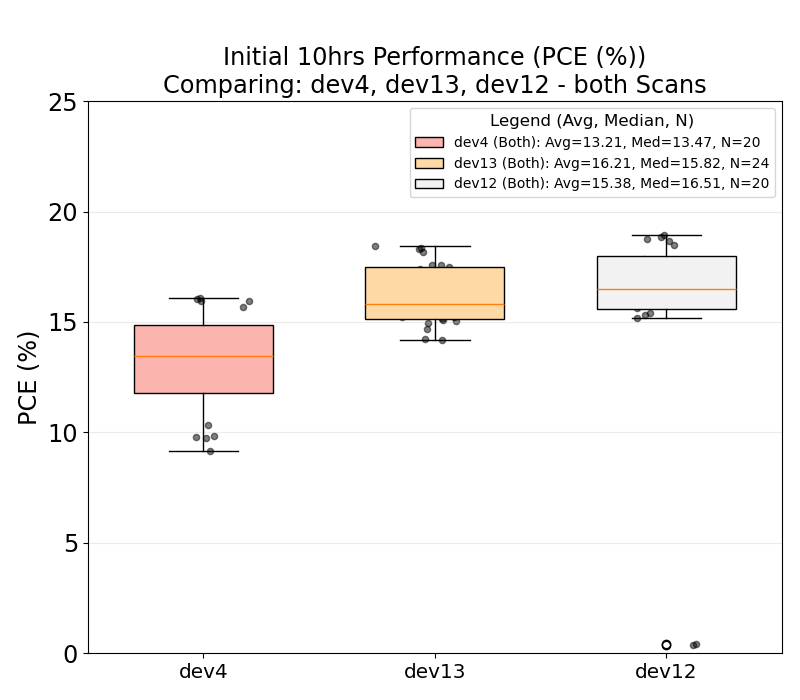

In [25]:
# Plotting logic from original cell 17, now calling plot_time_series_from_form
plot_type_resp = form_responses_dictionary["Plot type?"]
parameter_ylabel_resp = form_responses_dictionary['Parameter to plot?']
direction_response_resp = form_responses_dictionary["Scan direction?"]

parameter_col_code_plot, parameter_label_plot = get_parameter_details(parameter_ylabel_resp)

if plot_type_resp == "Time series":
    print(f"Plotting Time Series for: {parameter_label_plot}")
    y_limits_ts = None
    if parameter_col_code_plot == "pce": 
        y_limits_ts = [0, 20]

    fig_ts = plot_time_series_from_form(
        df_list_processed=jv_test_data_list_clumped, 
        sample_ids_selected=sample_ids_selected_from_form,
        parameter_to_plot=parameter_col_code_plot, 
        parameter_ylabel=parameter_label_plot, 
        direction_response=direction_response_resp,
        stability_tests_df=stability_tests_df,
        min_base_time_overall=min_base_time_for_plots,
        y_limits_param=y_limits_ts
    )
    plt.show()

elif plot_type_resp == "Box plot":
    print(f"Plotting Initial Box Plot for: {parameter_label_plot}")
    #This is where you select the time for the box plot
    initial_period_hours_bp = 10 
    time_interval_for_initial_bp = []

    if not jv_test_recent_values.empty and 'abs_epoch_time' in jv_test_recent_values.columns:
        df_for_time_ref_bp = jv_test_recent_values[jv_test_recent_values['sample_id'].isin(sample_ids_selected_from_form)]
        if not df_for_time_ref_bp.empty and not df_for_time_ref_bp['abs_epoch_time'].isnull().all():
            min_epoch_bp = df_for_time_ref_bp['abs_epoch_time'].min()
            if pd.notna(min_epoch_bp):
                start_epoch_bp = min_epoch_bp
                end_epoch_bp = min_epoch_bp + (initial_period_hours_bp * 3600)
                time_interval_for_initial_bp = [start_epoch_bp, end_epoch_bp]
            else:
                print("WARNING: Cannot determine min_epoch for box plot time interval due to NaN values.")
        else:
            print("WARNING: No data for selected samples to determine box plot time interval.")
    else:
        print("WARNING: jv_test_recent_values is empty or missing 'abs_epoch_time'. Cannot determine box plot time interval.")

    if time_interval_for_initial_bp:
        short_labels_bp = [s.split('_')[-1] if '_' in s else s for s in sample_ids_selected_from_form]
        plot_title_bp = (f"Initial {initial_period_hours_bp}hrs Performance ({parameter_ylabel_resp})\n"
                         f"Comparing: {', '.join(short_labels_bp)} - {direction_response_resp} Scans")
        
        y_limits_bp_map_val = {"pce": [0, 25], "voc_v": [0.5, 1.3], "jsc_ma": [0, 30], "ff": [0, 90]}
        y_limits_val_bp = y_limits_bp_map_val.get(parameter_col_code_plot, [None, None])

        fig_box = my_boxplot_comparison1(
            main_df_with_abs_time=jv_test_recent_values.copy(), 
            time_interval_epoch=time_interval_for_initial_bp,
            list_of_sample_ids=sample_ids_selected_from_form,
            parameter_to_plot=parameter_col_code_plot,
            scan_direction_to_plot=direction_response_resp.upper() if direction_response_resp.lower() != 'both' else 'Both',
            plot_title=plot_title_bp,
            y_axis_label=parameter_label_plot,
            y_limits=y_limits_val_bp,
            short_sample_labels=short_labels_bp
        )
        plt.show()
    else:
        print("Could not generate box plot due to issues with time interval determination.")
else:
    print(f"Plot type '{plot_type_resp}' not handled by this section.")


--- Manual Box Plot Configuration ---
Generating Manual Box Plot for: Manual Plot: dev4 vs dev1 PCE (Reverse, Specified Time)


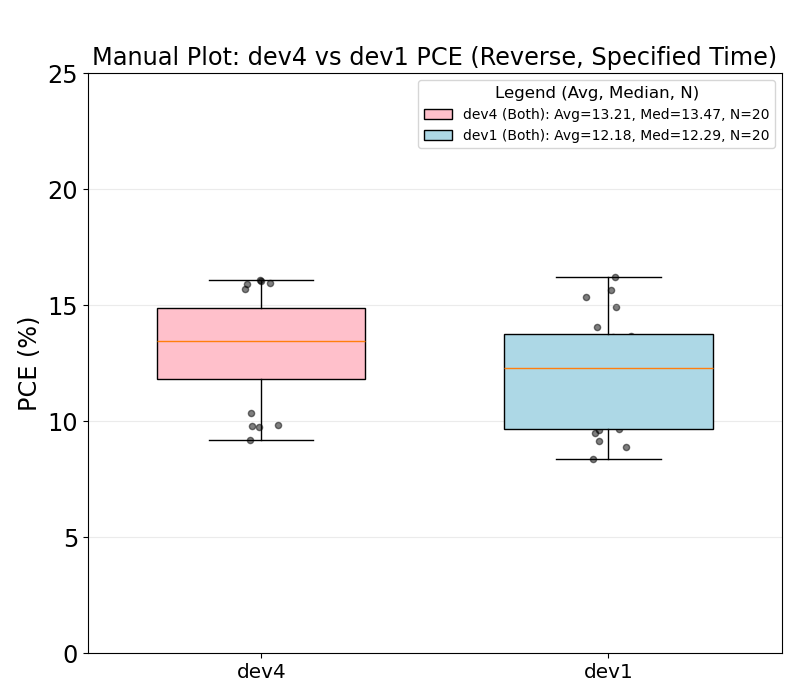

In [31]:
print("--- Manual Box Plot Configuration ---")

# Define manual parameters
manual_list_of_sample_ids = ['05072025_CubicPV_VRD-5_dev4', '05072025_CubicPV_VRD-5_dev1'] 
manual_parameter_label = 'PCE (%)'
manual_scan_direction_display = 'Both' # Scan direction: "F" (Forward), "R" (Reverse), or "Both".
manual_plot_title = "Manual Plot: dev4 vs dev1 PCE (Reverse, Specified Time)"
manual_y_limits = [0, 25]
manual_start_time_str = "2025-05-07 12:30:00"
manual_end_time_str = "2025-05-07 14:30:00"
manual_short_labels = ['dev4', 'dev1']
manual_box_colors = ['pink', 'lightblue']

manual_parameter_code, manual_y_axis_label = get_parameter_details(manual_parameter_label)
manual_scan_code = manual_scan_direction_display.upper() if manual_scan_direction_display.lower() != 'both' else 'Both'

manual_time_interval_epoch = []
try:
    start_ep = timestamp_to_epoch(manual_start_time_str)
    end_ep = timestamp_to_epoch(manual_end_time_str)
    if start_ep is not None and end_ep is not None:
        manual_time_interval_epoch = [start_ep, end_ep]
    else:
        raise ValueError("Invalid timestamp format for manual plot.")
except ValueError as e:
    print(f"ERROR in manual time input: {e}. Please use YYYY-MM-DD HH:MM:SS format.")

if manual_list_of_sample_ids and manual_parameter_code and manual_time_interval_epoch and not jv_test_recent_values.empty:
    print(f"Generating Manual Box Plot for: {manual_plot_title}")
    fig_manual_box = my_boxplot_comparison1(
        main_df_with_abs_time=jv_test_recent_values.copy(),
        time_interval_epoch=manual_time_interval_epoch,
        list_of_sample_ids=manual_list_of_sample_ids,
        parameter_to_plot=manual_parameter_code,
        scan_direction_to_plot=manual_scan_code,
        plot_title=manual_plot_title,
        y_axis_label=manual_y_axis_label,
        y_limits=manual_y_limits,
        short_sample_labels=manual_short_labels,
        box_colors=manual_box_colors
    )
    plt.show()
elif jv_test_recent_values.empty:
    print("WARNING: jv_test_recent_values is empty. Cannot generate manual box plot.")
else:
    print("Manual box plot parameters not fully set or data missing.")


--- Manual Line Plot Configuration ---
Generating Manual Line Plot for: Manual Time Series: PCE for dev4 (Reverse Scans)


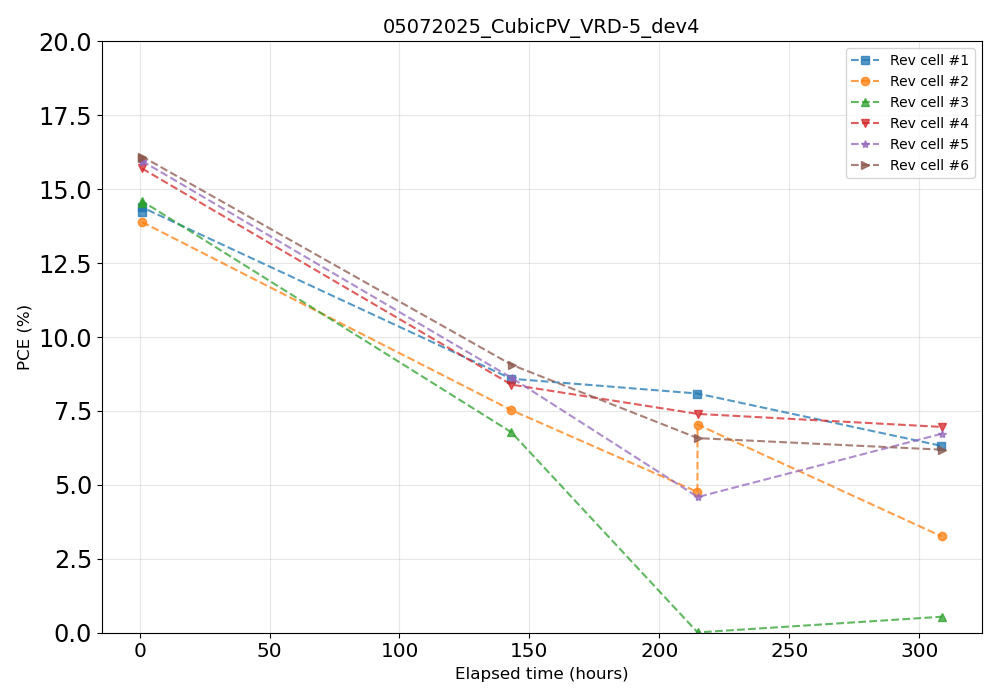

In [18]:
# manual_line_plot.py

# This section allows for manual definition of parameters for a time-series plot.
# Users can edit the parameters directly in this script.

print("--- Manual Line Plot Configuration ---")

# === Manually Define Your Plot Parameters Below ===

# Select one sample ID for detailed plot, or multiple for an overview plot
manual_line_sample_ids = ['05072025_CubicPV_VRD-5_dev4']  # Example: a single sample
# manual_line_sample_ids = ['05072025_CubicPV_VRD-5_dev4', '05072025_CubicPV_VRD-5_dev1'] # Example: multiple for overview

manual_line_parameter_label = 'PCE (%)'  # Options: 'PCE (%)', 'FF (%)', 'Voc (V)', 'Jsc (mA/cm^2)', etc.
manual_line_scan_direction = 'Reverse'   # Options: 'Forward', 'Reverse', or 'Both'
manual_line_plot_title = "Manual Time Series: PCE for dev4 (Reverse Scans)"

# Optional: Define Y-axis limits [min, max]. Set to [None, None] for auto-scaling or use specific defaults.
manual_line_y_limits = [0, 20]
# manual_line_y_limits = [None, None] # For auto-scaling y-axis

# Optional: Define a specific time interval for the plot (in 'YYYY-MM-DD HH:MM:SS' format).
# Leave start_time_str and end_time_str as empty strings ('') to plot all available data for the sample.
manual_line_start_time_str = ""  # Example: "2025-05-07 12:00:00"
manual_line_end_time_str = ""    # Example: "2025-05-07 18:00:00"

# --- End of Manual Parameter Definition ---

# Retrieve plotting parameter info
manual_line_parameter_col_code, manual_line_parameter_y_label = get_parameter_details(manual_line_parameter_label)

# Prepare JV data for plotting
jv_data_for_manual_line = []

if not jv_test_recent_values.empty:
    for s_id in manual_line_sample_ids:
        df_s = jv_test_recent_values[jv_test_recent_values["sample_id"] == s_id].copy()
        if not df_s.empty and 'abs_epoch_time' not in df_s.columns and \
           'base_time' in df_s.columns and 'elapsed_time' in df_s.columns:
            try:
                base_time_numeric = pd.to_numeric(df_s['base_time'], errors='coerce')
                elapsed_time_numeric = pd.to_numeric(df_s['elapsed_time'], errors='coerce')
                df_s['abs_epoch_time'] = base_time_numeric + (60.0 * elapsed_time_numeric)
            except Exception as e:
                print(f"WARNING: Could not create 'abs_epoch_time' for manual line plot sample {s_id}: {e}")
        jv_data_for_manual_line.append(df_s)
else:
    print("WARNING: jv_test_recent_values is empty. Cannot generate manual line plot.")

# Check if there’s any valid data
if not any(not df.empty for df in jv_data_for_manual_line if df is not None):
    print(f"WARNING: No JV data found for the manually selected sample(s): {', '.join(manual_line_sample_ids)}")
else:
    # Clump the data for the selected samples
    df_list_processed_manual_line = dataframe_clumping(jv_data_for_manual_line)

    # Determine min base time for consistent time axis
    min_base_time_for_plots_manual = None
    if not jv_test_recent_values.empty and 'base_time' in jv_test_recent_values.columns:
        numeric_base_times = pd.to_numeric(jv_test_recent_values['base_time'], errors='coerce').dropna()
        if not numeric_base_times.empty:
            min_base_time_for_plots_manual = numeric_base_times.min()

    # Generate the plot
    print(f"Generating Manual Line Plot for: {manual_line_plot_title}")
    fig_manual_line = plot_time_series_from_form(
        df_list_processed=df_list_processed_manual_line,
        sample_ids_selected=manual_line_sample_ids,
        parameter_to_plot=manual_line_parameter_col_code,
        parameter_ylabel=manual_line_parameter_y_label,
        direction_response=manual_line_scan_direction,
        # stability_tests_df=stability_tests_df,  # Uncomment if using stability overlays
        # min_base_time_overall=min_base_time_for_plots_manual,  # Uncomment for consistent x-axis if needed
        y_limits_param=manual_line_y_limits
    )

    import matplotlib.pyplot as plt
    plt.show()
